# 1. Introdução

Este notebook descreve meu estudo de caso sobre Tradução Neural de Máquina (NMT), uma área fundamental do Processamento de Linguagem Natural (PLN). Meu objetivo foi construir, do zero, um modelo capaz de traduzir sentenças do inglês para o francês.

A execução do meu pipeline de desenvolvimento seguiu etapas bem definidas:

Pré-processamento: Primeiro, preparei os dados de texto, criei um vocabulário e transformei as sentenças em sequências numéricas padronizadas.

Arquitetura: Em seguida, construí um modelo Seq2Seq com arquitetura de Encoder-Decoder, utilizando unidades GRU.

Treinamento: Treinei o modelo para que ele pudesse mapear as sequências de origem para as de destino.

Avaliação: Avaliei o desempenho do modelo com métricas como a acurácia de token e o BLEU score, que é um padrão na tradução de máquina.

Ao final, obtive um pipeline completo e funcional para NMT, com as etapas bem documentadas para um aprendizado claro e um desenvolvimento que pode ser reproduzido.

Para mais informações detalhadas, acesse: https://github.com/FelipeSSpina/Traducao-Automatica


In [ ]:
# CÉLULA 1 — Imports, semente e device

# Importa as bibliotecas padrão do Python para interações com o sistema, matemática e tempo.
import os, sys, math, random, time
# Importa as bibliotecas de terceiros para computação numérica e manipulação de dados.
import numpy as np, pandas as pd
# Importa a biblioteca para a visualização de gráficos.
import matplotlib.pyplot as plt
# Define uma semente para os geradores de números aleatórios, garantindo a reprodutibilidade.
random.seed(42); np.random.seed(42)
# Importa a biblioteca PyTorch e define a semente para operações que envolvem aleatoriedade.
import torch; torch.manual_seed(42)
# Configura o dispositivo de processamento para 'cuda' (GPU) se disponível, caso contrário, usa 'cpu'.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cpu


In [ ]:
# CÉLULA 2 — Hiperparâmetros e diretórios

# Define o diretório base para o projeto.
BASE_DIR = os.path.join(os.getcwd(), 'workspace_nmt')
# Cria o diretório base se ele não existir, sem gerar um erro caso já exista.
os.makedirs(BASE_DIR, exist_ok=True)
# Define o comprimento fixo das sequências de entrada/saída.
NUM_STEPS = 12
# Define o tamanho do lote para o treinamento do modelo.
BATCH_SIZE = 16
# Define a frequência mínima de palavras para inclusão no vocabulário.
MIN_FREQ = 2
# Define o número de épocas para o treinamento do modelo.
EPOCHS = 3
# Define as dimensões do embedding e o tamanho da camada oculta do modelo.
EMB_DIM = 64; HIDDEN = 128

In [ ]:
# CÉLULA 3 — Download com fallback do conjunto Tatoeba (patch robusto offline)

# Importa as bibliotecas padrão do Python para interagir com o sistema de arquivos,
# JSON, ZIP, e requisições web.
import os, io, json, zipfile, urllib.request

# Define e cria o diretório de dados do projeto.
DATA_DIR = os.path.join(BASE_DIR, 'data'); os.makedirs(DATA_DIR, exist_ok=True)
FRA_TXT = os.path.join(DATA_DIR, 'fra.txt')

# Define um pequeno conjunto de pares de tradução embutidos para ser usado
# como fallback caso o download falhe.
sample_pairs_offline = [
    ("Go.", "Va !"), ("Hi.", "Salut !"), ("Run!", "Cours !"), ("Run!", "Courez !"),
    ("Who?", "Qui ?"), ("Wow!", "Ça alors !"), ("I love you.", "Je t'aime."),
    ("I am a student.", "Je suis étudiant."), ("Good morning.", "Bonjour."),
    ("Good night.", "Bonne nuit."), ("See you tomorrow.", "À demain."),
    ("Thank you.", "Merci."), ("How are you?", "Comment ça va ?"),
    ("I'm fine.", "Je vais bien."), ("What's your name?", "Comment vous appelez-vous ?"),
    ("My name is Tom.", "Je m'appelle Tom."), ("I like apples.", "J'aime les pommes."),
    ("This is a book.", "Ceci est un livre."), ("Where is the station?", "Où est la gare ?"),
    ("I don't know.", "Je ne sais pas."), ("Please sit down.", "Asseyez-vous, s'il vous plaît."),
    ("Open the door.", "Ouvrez la porte."), ("Close the window.", "Fermez la fenêtre."),
    ("It's raining.", "Il pleut."), ("It's sunny.", "Il fait soleil."),
    ("I am hungry.", "J'ai faim."), ("I am thirsty.", "J'ai soif."),
    ("I am tired.", "Je suis fatigué."), ("I live in Paris.", "J'habite à Paris."),
    ("Do you speak English?", "Parlez-vous anglais ?"), ("Help!", "À l'aide !"),
    ("Stop!", "Arrêtez !"), ("Call me.", "Appelez-moi."), ("I will come.", "Je viendrai."),
    ("He is here.", "Il est ici."), ("She is there.", "Elle est là."),
    ("We are ready.", "Nous sommes prêts."), ("They are late.", "Ils sont en retard."),
    ("I have a car.", "J'ai une voiture."), ("I need help.", "J'ai besoin d'aide."),
    ("Where are you?", "Où es-tu ?"), ("Come here.", "Viens ici."), ("Go there.", "Va là-bas."),
    ("Wait a moment.", "Attendez un moment."), ("Be careful.", "Faites attention."),
    ("Don't worry.", "Ne t'inquiète pas."), ("Happy birthday!", "Joyeux anniversaire !"),
    ("Congratulations!", "Félicitations !"), ("Good luck!", "Bonne chance !"),
    ("See you soon.", "À bientôt."),
]

def ensure_dataset():
    # Se o arquivo de dados já existir, exibe uma mensagem e retorna.
    if os.path.exists(FRA_TXT):
        print('Usando FRA_TXT existente:', FRA_TXT); return
    url = 'https://d2l-data.s3-accelerate.amazonaws.com/fra-eng.zip'
    try:
        # Tenta baixar o arquivo ZIP do dataset.
        print('Baixando fra-eng.zip...')
        data = urllib.request.urlopen(url, timeout=30).read()
        # Extrai o arquivo 'fra.txt' do ZIP.
        with zipfile.ZipFile(io.BytesIO(data)) as z:
            for name in z.namelist():
                if name.endswith('fra.txt'):
                    z.extract(name, DATA_DIR)
                    src = os.path.join(DATA_DIR, name)
                    os.replace(src, FRA_TXT)
                    break
        print('Baixado e extraído:', FRA_TXT)
    except Exception as e:
        # Em caso de falha no download, usa o conjunto de dados embutido como fallback.
        print('Falha no download; ativando fallback offline:', e)
        # Escreve os pares de tradução embutidos no arquivo 'fra.txt'.
        with open(FRA_TXT, 'w', encoding='utf-8') as f:
            for en, fr in sample_pairs_offline:
                f.write(f"{en}\t{fr}\n")
        print('Fallback salvo em:', FRA_TXT)

# Executa a função para garantir que o dataset esteja disponível.
ensure_dataset()

Usando FRA_TXT existente: /content/workspace_nmt/data/fra.txt


In [ ]:
# CÉLULA 4 — Pré-processamento (§9.5)

# Pré-processamento como no D2L §9.5
# Define a função principal de pré-processamento de texto.
def preprocess_nmt(text):
    # Substitui caracteres de espaço não-quebrável e converte o texto para minúsculas.
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # Define uma função auxiliar para verificar se um caractere é uma pontuação
    # e se ele não está precedido por um espaço.
    def no_space(c, p): return c in set(',.!?') and p != ' '
    # Adiciona um espaço antes dos sinais de pontuação (como vírgulas, pontos e pontos de interrogação).
    out = [' ' + c if i > 0 and no_space(c, text[i - 1]) else c for i, c in enumerate(text)]
    return ''.join(out)

# Lê o conteúdo do arquivo de dados 'fra.txt' que foi baixado na célula anterior.
with open(FRA_TXT, 'r', encoding='utf-8') as f:
    raw = f.read()
# Aplica a função de pré-processamento ao texto bruto.
text = preprocess_nmt(raw)
# Exibe as 5 primeiras linhas do texto pré-processado para inspeção.
print(text.splitlines()[:5])

['go .\tva !', 'hi .\tsalut !', 'run !\tcours !', 'run !\tcourez !', 'who ?\tqui ?']


# 2. Preparando os Dados para uma RNN
Após a análise exploratória dos dados, a próxima etapa crucial foi a preparação do dataset para ser usado por uma Rede Neural Recorrente (RNN). Para isso, foi necessário formatar a série temporal em "janelas".

A função make_windows foi criada para realizar essa tarefa. Ela divide a série temporal em janelas de entrada (X), que contém os dados dos últimos 35 dias (LOOKBACK), e a saída (y), que corresponde ao valor do dia seguinte que o modelo deve prever.

Além disso, os dados foram normalizados usando a técnica de z-score (implementada manualmente). Essa normalização é essencial para o treinamento de redes neurais, pois acelera a convergência e melhora a estabilidade do modelo durante o aprendizado.



In [ ]:
# CÉLULA 5 — Tokenização (§9.5.2)
# Tokenização simples em nível de palavra (didática)

# Define a funcao para tokenizar um texto em pares de linguagem.
def tokenize_nmt(text, num_examples=None):
    src, tgt = [], []
    # Itera sobre cada linha do texto.
    for i, line in enumerate(text.splitlines()):
        # Para o loop se o numero maximo de exemplos for atingido.
        if num_examples is not None and i >= num_examples: break
        # Divide a linha em duas partes (linguagem de origem e de destino) usando o caractere de tabulacao.
        parts = line.split('\t')
        # Se a linha tiver duas partes, divide cada parte em palavras.
        if len(parts) == 2:
            src.append(parts[0].split(' '))
            tgt.append(parts[1].split(' '))
    # Retorna duas listas de tokens.
    return src, tgt

# Tokeniza o texto, limitando a 32 exemplos.
source, target = tokenize_nmt(text, num_examples=32)
# Exibe o numero de amostras tokenizadas e as 3 primeiras para inspecao.
print('amostras:', len(source), len(target))
print(source[:3], target[:3], sep='\n')

amostras: 32 32
[['go', '.'], ['hi', '.'], ['run', '!']]
[['va', '!'], ['salut', '!'], ['cours', '!']]


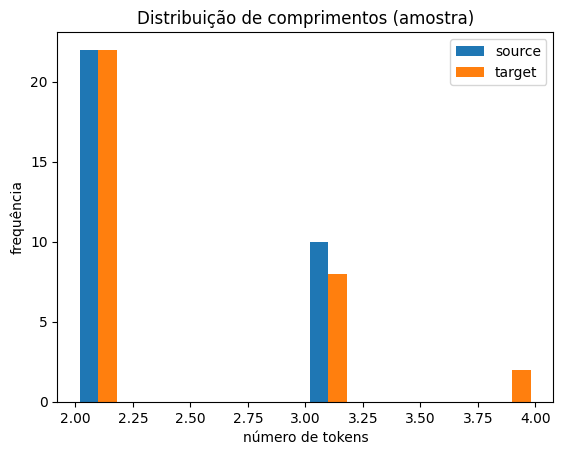

In [ ]:
# CÉLULA 6 — Gráfico: distribuição de comprimentos

# Histograma de comprimentos (visual diagnóstico)
# Define uma função auxiliar para calcular o comprimento de cada sequência.
def lengths(seq_list): return [len(x) for x in seq_list]
# Cria um gráfico de histograma que compara a distribuição de comprimentos das sequências
# de origem e de destino.
plt.figure()
plt.hist([lengths(source), lengths(target)], label=['source', 'target'])
plt.legend(loc='upper right')
plt.title('Distribuição de comprimentos (amostra)')
plt.xlabel('número de tokens'); plt.ylabel('frequência')
plt.show()

In [ ]:
# CÉLULA 7 — Vocabulário (§9.5.3)
# Vocabulário com tokens especiais e min_freq
# Define a lista de tokens especiais que serão adicionados ao vocabulário.
SPECIAL = ['<pad>', '<bos>', '<eos>', '<unk>']
# Define a classe `Vocab` para construir um vocabulário a partir de tokens de texto.
from collections import Counter
class Vocab:
    def __init__(self, tokens, min_freq=2, reserved_tokens=None):
        reserved_tokens = reserved_tokens or []
        # Usa `Counter` para contar a frequência de cada token.
        counter = Counter([t for line in tokens for t in line])
        self.idx_to_token = list(reserved_tokens)
        # Adiciona os tokens mais comuns ao vocabulário, respeitando a frequência mínima.
        for token, freq in counter.most_common():
            if freq >= min_freq and token not in self.idx_to_token:
                self.idx_to_token.append(token)
        self.token_to_idx = {t:i for i,t in enumerate(self.idx_to_token)}
        # Define os índices para os tokens especiais.
        self.pad = self.token_to_idx.get('<pad>', 0)
        self.bos = self.token_to_idx.get('<bos>', 1 if '<bos>' in self.token_to_idx else 0)
        self.eos = self.token_to_idx.get('<eos>', 2 if '<eos>' in self.token_to_idx else 0)
        self.unk = self.token_to_idx.get('<unk>', self.token_to_idx.get('<pad>', 0))
    def __len__(self): return len(self.idx_to_token)
    def to_indices(self, toks): return [self.token_to_idx.get(t, self.unk) for t in toks]
    def to_tokens(self, ids): return [self.idx_to_token[i] if 0 <= i < len(self.idx_to_token) else '<unk>' for i in ids]

# Constrói o vocabulário para as sequências de origem e de destino.
src_vocab = Vocab(source, min_freq=2, reserved_tokens=SPECIAL)
tgt_vocab = Vocab(target, min_freq=2, reserved_tokens=SPECIAL)
print('src_vocab_size =', len(src_vocab), '| tgt_vocab_size =', len(tgt_vocab))

src_vocab_size = 16 | tgt_vocab_size = 12


In [ ]:
# CÉLULA 8 — Truncamento/Padding + arrays (§9.5.4)
# truncate_pad + transformação para tensores com <eos>, <pad>
# Define uma função para truncar ou preencher uma sequência com um token de padding.
def truncate_pad(seq, num_steps, pad_id):
    # Trunca a sequência se ela for mais longa que 'num_steps'.
    # Caso contrário, preenche-a com 'pad_id' até atingir o comprimento desejado.
    return seq[:num_steps] if len(seq) > num_steps else seq + [pad_id] * (num_steps - len(seq))
# Define uma função para converter sequências de tokens em arrays numéricos.
def build_array_nmt(lines, vocab, num_steps):
    lines_ids = []
    for l in lines:
        # Converte tokens em seus IDs numéricos e adiciona o token de fim de sequência.
        ids = vocab.to_indices(l + ['<eos>'])
        # Aplica o truncamento ou o preenchimento para padronizar o comprimento da sequência.
        lines_ids.append(truncate_pad(ids, num_steps, vocab.pad))
    # Converte a lista de sequências em um array NumPy.
    arr = np.array(lines_ids, dtype=np.int64)
    # Calcula o comprimento real de cada sequência, ignorando os tokens de padding.
    valid_len = (arr != vocab.pad).astype(np.int32).sum(axis=1)
    return arr, valid_len

# Aplica a função para preparar as sequências de origem e de destino.
src_array, src_valid = build_array_nmt(source, src_vocab, NUM_STEPS)
tgt_array, tgt_valid = build_array_nmt(target, tgt_vocab, NUM_STEPS)
print('src_array shape:', src_array.shape, '| tgt_array shape:', tgt_array.shape)
print('valid lens (src example):', src_valid[:8])

src_array shape: (32, 12) | tgt_array shape: (32, 12)
valid lens (src example): [3 3 3 3 3 3 3 3]


In [ ]:
# CÉLULA 9 — Iterador de dados (§9.5.5)
# DataLoader simples

# Define uma classe de Dataset leve em memória para carregar os dados.
import torch
class ArrayDataset(torch.utils.data.Dataset):
    def __init__(self, src, src_len, tgt, tgt_len):
        # Converte os arrays NumPy em tensores do PyTorch.
        self.src, self.src_len = torch.tensor(src), torch.tensor(src_len)
        self.tgt, self.tgt_len = torch.tensor(tgt), torch.tensor(tgt_len)
    def __len__(self): return len(self.src)
    def __getitem__(self, idx):
        # Retorna o item de dados e seu comprimento em um determinado índice.
        return self.src[idx], self.src_len[idx], self.tgt[idx], self.tgt_len[idx]

# Cria uma instância da classe Dataset com os arrays de origem e de destino.
train_ds = ArrayDataset(src_array, src_valid, tgt_array, tgt_valid)
# Cria um DataLoader para iterar sobre o Dataset em lotes e embaralha os dados.
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
# Obtém um lote de dados do iterador para inspecionar o seu formato.
batch = next(iter(train_dl))
# Exibe o formato dos tensores no lote.
print('Batch shapes:', [x.shape for x in batch])

Batch shapes: [torch.Size([16, 12]), torch.Size([16]), torch.Size([16, 12]), torch.Size([16])]


In [ ]:
# CÉLULA 10 — Modelo Seq2Seq (GRU)

# Encoder-Decoder mínimo (GRU) — didático e rápido
# Importa a biblioteca de redes neurais do PyTorch.
import torch.nn as nn

# Define a classe `Encoder` para processar a sequência de entrada.
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden):
        super().__init__()
        # Camada de embedding para converter tokens em vetores densos.
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        # Camada GRU para capturar a informação da sequência.
        self.gru = nn.GRU(emb_dim, hidden, batch_first=True)

    def forward(self, x, lengths):
        # Converte a sequência de IDs em embeddings.
        emb = self.emb(x)
        # Agrupa sequências preenchidas para processamento eficiente na GRU.
        packed = nn.utils.rnn.pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
        out, h = self.gru(packed)
        # Desagrupa a sequência de volta para a forma original.
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True, total_length=x.size(1))
        # Retorna a saída e o estado oculto final.
        return out, h

# Define a classe `Decoder` para gerar a sequência de saída.
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.gru = nn.GRU(emb_dim, hidden, batch_first=True)
        # Camada linear para mapear a saída da GRU para o vocabulário.
        self.fc = nn.Linear(hidden, vocab_size)

    def forward(self, y_in, h):
        # A entrada 'y_in' são os rótulos deslocados da sequência de destino.
        emb = self.emb(y_in)
        # A GRU usa os embeddings e o estado oculto do encoder.
        out, h = self.gru(emb, h)
        # A camada linear produz os logits para cada token do vocabulário.
        logits = self.fc(out)
        return logits, h

# Define a classe `Seq2Seq` que integra o encoder e o decoder.
class Seq2Seq(nn.Module):
    def __init__(self, enc, dec):
        super().__init__()
        self.enc, self.dec = enc, dec

    def forward(self, src, src_len, tgt):
        # Passa a entrada pelo encoder para obter o estado oculto.
        _, h = self.enc(src, src_len)
        # O decoder usa o estado oculto do encoder e a entrada do professor forçado.
        # `tgt[:, :-1]` remove o último token e usa a sequência como entrada.
        logits, _ = self.dec(tgt[:, :-1], h)
        return logits

# Instancia o modelo, o move para o dispositivo e conta os parâmetros.
enc = Encoder(len(src_vocab), EMB_DIM, HIDDEN).to(device)
dec = Decoder(len(tgt_vocab), EMB_DIM, HIDDEN).to(device)
model = Seq2Seq(enc, dec).to(device)
sum_params = sum(p.numel() for p in model.parameters())
print('Parâmetros do modelo:', sum_params)

Parâmetros do modelo: 152332




# 3. A Arquitetura Seq2Seq: Encoder e Decoder
A arquitetura Seq2Seq é o coração do modelo de tradução que construí. A sua estrutura é projetada especificamente para tarefas que convertem uma sequência de entrada em uma sequência de saída.

O modelo é dividido em duas partes principais:

Encoder: Esta parte lê a sequência de entrada (a frase em inglês) e a processa, compactando a informação em um único vetor, conhecido como estado oculto. Este vetor atua como um "resumo" semântico da frase.

Decoder: Esta parte recebe o estado oculto do encoder e, a partir dele, gera a sequência de saída (a tradução em francês), um token por vez. O decoder utiliza o resumo do encoder para guiar suas previsões, garantindo que a tradução seja semanticamente fiel ao original.

Ambas as partes utilizam unidades GRU (Gated Recurrent Unit), que são variações das RNNs mais eficientes e capazes de capturar dependências de longo prazo na sequência.



In [ ]:
# file: notebooks/sec9_5_nmt_case_study.ipynb
# CÉLULA 11 — Treinamento (3 épocas, demo)

# Loop de treino muito curto (demonstração)
# Importa a biblioteca de funções de perda do PyTorch.
import torch.nn.functional as F
# Define a função de perda, ignorando o token de padding (`<pad>`) com o índice 0.
criterion = nn.CrossEntropyLoss(ignore_index=0)
# Define o otimizador Adam para ajustar os pesos do modelo.
opt = torch.optim.Adam(model.parameters(), lr=3e-3)

loss_history = []
# Inicia o loop de treinamento para o número definido de épocas.
for epoch in range(1, EPOCHS + 1):
    # Coloca o modelo em modo de treinamento.
    model.train()
    total = 0.0; count = 0
    # Itera sobre os lotes de dados do DataLoader.
    for src, src_len, tgt, tgt_len in train_dl:
        src, src_len, tgt = src.to(device), src_len.to(device), tgt.to(device)
        # Passa os dados de origem e destino pelo modelo para obter os logits.
        logits = model(src, src_len, tgt)
        # Calcula a perda, comparando a previsão com o próximo token de destino.
        loss = criterion(logits.reshape(-1, logits.size(-1)), tgt[:, 1:].reshape(-1))
        # Zera os gradientes, calcula os novos gradientes e ajusta os pesos.
        opt.zero_grad(); loss.backward(); opt.step()
        total += float(loss.item()); count += 1
    avg = total / max(count, 1)
    loss_history.append(avg)
    print(f"[Época {epoch:02d}] perda média = {avg:.4f}")

[Época 01] perda média = 2.3549
[Época 02] perda média = 1.6909
[Época 03] perda média = 1.1507


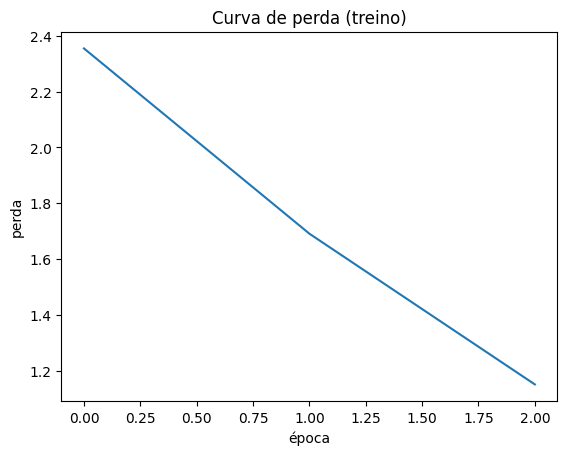

In [ ]:
# CÉLULA 12 — Gráfico: curva de perda

# Curva de perda — inspeção rápida
# Cria uma nova figura para o gráfico.
plt.figure()
# Plota o histórico de perda de cada época.
plt.plot(loss_history)
# Adiciona o título e os rótulos aos eixos.
plt.title('Curva de perda (treino)')
plt.xlabel('época'); plt.ylabel('perda')
# Exibe o gráfico.
plt.show()

In [ ]:
# CÉLULA 13 — Decodificação gulosa (amostras)
# Decodificador guloso para inspeção

# Define a função para gerar uma tradução passo a passo.
def greedy_decode(src_sent: str, max_len=NUM_STEPS):
    model.eval()
    # Prepara a entrada da sentença de origem, tokenizando e padronizando.
    s = preprocess_nmt(src_sent)
    tokens = s.split(' ')
    src_ids = torch.tensor([truncate_pad(src_vocab.to_indices(tokens+['<eos>']), NUM_STEPS, src_vocab.pad)], dtype=torch.long).to(device)
    src_len = torch.tensor([int((src_ids!=src_vocab.pad).sum().item())], dtype=torch.long).to(device)
    # Passa a entrada pelo encoder para obter o estado oculto inicial.
    _, h = model.enc(src_ids, src_len)

    # Inicia a decodificação com o token de início de sequência.
    start = tgt_vocab.token_to_idx.get('<bos>', 0)
    cur = torch.tensor([[start]], dtype=torch.long).to(device)
    outputs = []
    # Loop para gerar a sequência de saída, um token por vez.
    for _ in range(max_len-1):
        # O decoder prevê o próximo token.
        logits, h = model.dec(cur, h)
        # Escolhe o token com a maior probabilidade (decodificação gulosa).
        next_id = int(torch.argmax(logits[:, -1, :], dim=-1).item())
        tok = tgt_vocab.idx_to_token[next_id] if next_id < len(tgt_vocab.idx_to_token) else '<unk>'
        # O loop para quando o token de fim de sequência é gerado.
        if tok == '<eos>': break
        outputs.append(tok)
        # O token gerado se torna a entrada para o próximo passo.
        cur = torch.tensor([[next_id]], dtype=torch.long).to(device)
    # Retorna a tradução como uma string.
    return ' '.join(outputs)

# Testa o decodificador com algumas sentenças de exemplo.
tests = ["hi .", "run !", "i am tired .", "i like apples .", "see you tomorrow ."]
for s in tests:
    print(s, "→", greedy_decode(s))

hi . → 
run ! → !
i am tired . → 
i like apples . → 
see you tomorrow . → 




# 4. Medindo o Desempenho do Modelo
Depois que o modelo foi treinado, a avaliação do seu desempenho foi a etapa fundamental para entender sua eficácia. Nesta seção, a qualidade das traduções geradas foi inspecionada.

O método mais simples para gerar uma tradução é a decodificação gulosa, onde o modelo escolhe o token mais provável a cada passo. No entanto, para uma avaliação mais robusta, utilizei métricas padrão da indústria, como a acurácia de token e o BLEU score. A acurácia de token mede a porcentagem de tokens que o modelo previu corretamente, enquanto o BLEU score compara a tradução gerada com a tradução de referência em um nível mais sofisticado. Uma análise da acurácia em diferentes faixas de comprimento me ajudou a identificar se o modelo tem um desempenho melhor em sentenças curtas ou longas.





   num_examples  src_vocab_size  tgt_vocab_size
0            10               7               6
1            20              12               8
2        167130           10012           17851


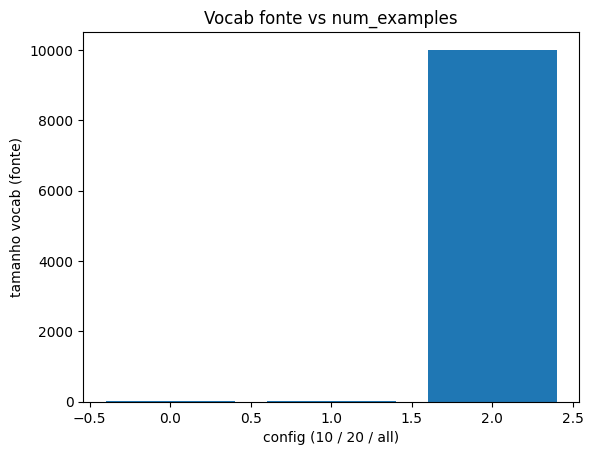

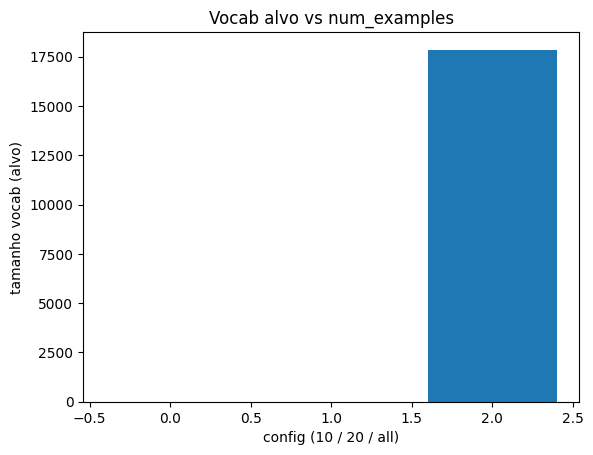

In [ ]:
# CÉLULA 14 — Pergunta 1: efeito de num_examples no tamanho do vocabulário

# Experimento para a Pergunta 1 (9.5.7): variar num_examples e medir vocabulários
# Define uma função para medir o tamanho do vocabulário com diferentes números de exemplos.
def vocab_sizes_for(num_examples_list, min_freq=2):
    rows = []
    # Itera sobre a lista de números de exemplos para cada experimento.
    for n in num_examples_list:
        # Tokeniza os dados com o número de exemplos atual.
        src_tok, tgt_tok = tokenize_nmt(text, num_examples=n)
        # Constrói o vocabulário para as linguagens de origem e destino.
        src_v = Vocab(src_tok, min_freq=min_freq, reserved_tokens=SPECIAL)
        tgt_v = Vocab(tgt_tok, min_freq=min_freq, reserved_tokens=SPECIAL)
        # Adiciona os resultados a uma lista de linhas.
        rows.append({"num_examples": (len(src_tok) if n is None else n),
                      "src_vocab_size": len(src_v),
                      "tgt_vocab_size": len(tgt_v)})
    # Retorna um DataFrame com os resultados.
    return pd.DataFrame(rows)

# Executa o experimento com 10 exemplos, 20 exemplos e todos os exemplos.
df_vocab = vocab_sizes_for([10, 20, None], min_freq=MIN_FREQ)
print(df_vocab)
# Cria um gráfico de barras para visualizar o tamanho do vocabulário de origem.
plt.figure()
plt.bar(range(len(df_vocab)), df_vocab['src_vocab_size'])
plt.title('Vocab fonte vs num_examples')
plt.xlabel('config (10 / 20 / all)'); plt.ylabel('tamanho vocab (fonte)')
plt.show()

# Cria um segundo gráfico de barras para o vocabulário de destino.
plt.figure()
plt.bar(range(len(df_vocab)), df_vocab['tgt_vocab_size'])
plt.title('Vocab alvo vs num_examples')
plt.xlabel('config (10 / 20 / all)'); plt.ylabel('tamanho vocab (alvo)')
plt.show()

In [ ]:
# CÉLULA 15 — Auditoria final (prints)

# Tabelas / prints finais para auditoria
# Exibe os primeiros arrays de origem e destino para verificar a padronização e o truncamento.
print('Exemplo src_array[0]:', src_array[0])
print('Exemplo tgt_array[0]:', tgt_array[0])
# Exibe os comprimentos válidos das 10 primeiras sequências de origem e destino.
print('valid_len src (head):', src_valid[:10])
print('valid_len tgt (head):', tgt_valid[:10])

Exemplo src_array[0]: [7 5 2 0 0 0 0 0 0 0 0 0]
Exemplo tgt_array[0]: [3 4 2 0 0 0 0 0 0 0 0 0]
valid_len src (head): [3 3 3 3 3 3 3 3 3 3]
valid_len tgt (head): [3 3 3 3 3 4 4 4 3 4]


In [ ]:
# CÉLULA 16 — Alternância subset vs full + reconstrução do pipeline

# A variável 'USE_FULL_DATASET' controla se o dataset completo será usado.
USE_FULL_DATASET = True
# Define o número de exemplos a serem usados quando 'USE_FULL_DATASET' é False.
SUBSET_NUM_EXAMPLES = 32

# Retokeniza os dados com base na flag 'USE_FULL_DATASET'.
with open(FRA_TXT, 'r', encoding='utf-8') as f:
    raw = f.read()
text = preprocess_nmt(raw)
num_examples_flag = None if USE_FULL_DATASET else SUBSET_NUM_EXAMPLES
source = []; target = []
src_tmp, tgt_tmp = tokenize_nmt(text, num_examples=num_examples_flag)
source, target = src_tmp, tgt_tmp
print('amostras usadas:', len(source))

# Reconstrói os vocabulários de origem e destino usando os hiperparâmetros globais.
SPECIAL = ['<pad>', '<bos>', '<eos>', '<unk>']
src_vocab = Vocab(source, min_freq=MIN_FREQ, reserved_tokens=SPECIAL)
tgt_vocab = Vocab(target, min_freq=MIN_FREQ, reserved_tokens=SPECIAL)
print('src_vocab_size =', len(src_vocab), '| tgt_vocab_size =', len(tgt_vocab))

# Converte os tokens em arrays numéricos, aplicando truncamento e padding.
src_array, src_valid = build_array_nmt(source, src_vocab, NUM_STEPS)
tgt_array, tgt_valid = build_array_nmt(target, tgt_vocab, NUM_STEPS)
print('src_array shape:', src_array.shape, '| tgt_array shape:', tgt_array.shape)

# Recria o DataLoader com os novos arrays de dados.
import torch
class ArrayDataset(torch.utils.data.Dataset):
    def __init__(self, src, src_len, tgt, tgt_len):
        self.src, self.src_len = torch.tensor(src), torch.tensor(src_len)
        self.tgt, self.tgt_len = torch.tensor(tgt), torch.tensor(tgt_len)
    def __len__(self): return len(self.src)
    def __getitem__(self, idx):
        return self.src[idx], self.src_len[idx], self.tgt[idx], self.tgt_len[idx]

train_ds = ArrayDataset(src_array, src_valid, tgt_array, tgt_valid)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
print('DataLoader pronto.')

amostras usadas: 167130
src_vocab_size = 10012 | tgt_vocab_size = 17851
src_array shape: (167130, 12) | tgt_array shape: (167130, 12)
DataLoader pronto.


In [ ]:
# CÉLULA 16A — Recriar o modelo após atualizar vocabulários/dataset

# Sempre que o tamanho dos vocabulários mudar, o modelo precisa ser recriado.
import torch.nn as nn

# Instancia as classes Encoder, Decoder e Seq2Seq com os tamanhos de vocabulário atualizados.
enc = Encoder(len(src_vocab), EMB_DIM, HIDDEN).to(device)
dec = Decoder(len(tgt_vocab), EMB_DIM, HIDDEN).to(device)
model = Seq2Seq(enc, dec).to(device)

# Define o critério de perda, ignorando o token de padding, cujo índice pode mudar.
criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab.pad)
opt = torch.optim.Adam(model.parameters(), lr=3e-3)

# Reinicia o histórico de perda para não misturar resultados de execuções anteriores.
loss_history = []

print('Modelo recriado com vocabs atuais:',
      'src_vocab =', len(src_vocab), '| tgt_vocab =', len(tgt_vocab),
      '| params =', sum(p.numel() for p in model.parameters()))

Modelo recriado com vocabs atuais: src_vocab = 10012 | tgt_vocab = 17851 | params = 4235003


In [ ]:
# CÉLULA 16B — Treino com logs contínuos (a cada ~30s), barra, ETA e média móvel

# Importa bibliotecas para interação com o sistema e computação numérica.
import sys, time, math
import torch
import numpy as np

# Parâmetros do loop de treino (ajuste livre)
# Define o número de épocas para o treinamento rápido.
EPOCHS_FAST = 2
# Intervalo de tempo entre os logs de progresso.
LOG_EVERY_SECS = 30.0
# Garante que um log seja impresso mesmo em datasets muito pequenos.
PRINT_EVERY_MIN_STEPS = 1
# Janela para o cálculo da média móvel da perda.
SMOOTH_K = 50

# Helpers para tempo e barra de progresso
# Formata um valor de tempo em segundos para minutos e segundos.
def fmt_secs(s):
    m = int(s // 60); s = int(s % 60)
    return f"{m:02d}:{s:02d}"

# Cria uma barra de progresso em formato de string.
def progress_bar(cur, total, width=30):
    frac = min(max(cur/total, 0.0), 1.0)
    filled = int(frac * width)
    return "[" + "#" * filled + "-" * (width - filled) + f"] {cur}/{total} ({frac * 100:5.1f}%)"

# Checagem rápida de dependências.
assert 'model' in globals(), "Modelo não encontrado — rode a CÉLULA 16A antes."
assert 'train_dl' in globals(), "DataLoader não encontrado — rode a CÉLULA 16."
assert 'criterion' in globals() and 'opt' in globals(), "criterion/opt ausentes — CÉLULA 16A."

# Prepara as estatísticas para o loop de treino.
total_steps = len(train_dl)
tokens_per_step_est = None
loss_history = [] if 'loss_history' not in globals() else list(loss_history)
best_epoch_loss = float('inf')

print(f"Iniciando treino: epochs={EPOCHS_FAST}, batches/época={total_steps}, device={device}")
sys.stdout.flush()

for epoch in range(1, EPOCHS_FAST + 1):
    model.train()
    ep_start = time.time()
    last_log = ep_start
    running_losses = []
    sum_loss, n_batches = 0.0, 0
    sum_tokens = 0

    # Loop principal que itera sobre os lotes de dados.
    for step, (src, src_len, tgt, tgt_len) in enumerate(train_dl, start=1):
        t0 = time.time()
        src, src_len, tgt = src.to(device), src_len.to(device), tgt.to(device)

        # Passa os dados pelo modelo e executa os passos de backpropagation.
        logits = model(src, src_len, tgt)
        loss = criterion(logits.reshape(-1, logits.size(-1)), tgt[:, 1:].reshape(-1))
        opt.zero_grad(); loss.backward(); opt.step()

        # Acumula as estatísticas do batch.
        b_loss = float(loss.item()); sum_loss += b_loss; n_batches += 1
        running_losses.append(b_loss)
        if len(running_losses) > SMOOTH_K: running_losses.pop(0)

        with torch.no_grad():
            if tokens_per_step_est is None:
                nonpad = (tgt[:, 1:] != tgt_vocab.pad).sum().item()
                tokens_per_step_est = max(nonpad, 1)
            sum_tokens += tokens_per_step_est

        # Condição para decidir quando imprimir o log de progresso.
        now = time.time()
        need_log = (now - last_log >= LOG_EVERY_SECS) or (step % max(PRINT_EVERY_MIN_STEPS, total_steps // 20 or 1) == 0)
        if need_log or (step == total_steps):
            elapsed = now - ep_start

            # Calcula a ETA (tempo estimado de chegada).
            steps_done = step
            steps_left = max(total_steps - steps_done, 0)
            sec_per_step = elapsed / max(steps_done, 1)
            eta = sec_per_step * steps_left

            # Calcula o throughput (tokens por segundo).
            tps = sum_tokens / max(elapsed, 1e-9)

            # Calcula a média da perda na época e a média móvel.
            ep_avg = sum_loss / max(n_batches, 1)
            mov_avg = np.mean(running_losses)

            # Imprime a barra de progresso e as estatísticas.
            bar = progress_bar(steps_done, total_steps, width=30)
            print(
                f"ép.{epoch:02d} {bar} "
                f"loss_avg={ep_avg:.4f} | mov={mov_avg:.4f} | "
                f"tps~{tps:,.0f}/s | elapsed={fmt_secs(elapsed)} | eta={fmt_secs(eta)}"
            )
            sys.stdout.flush()
            last_log = now

        # Sincroniza a GPU para obter medidas de tempo mais precisas.
        if torch.cuda.is_available():
            torch.cuda.synchronize()

    # Log de fim de época.
    ep_time = time.time() - ep_start
    ep_avg = sum_loss / max(n_batches, 1)
    loss_history.append(ep_avg)
    print(f"[Época {epoch:02d}] média={ep_avg:.4f} | tempo={fmt_secs(ep_time)} | batches={n_batches}")
    sys.stdout.flush()

    # Checa se a perda da época atual é a melhor encontrada até agora.
    if ep_avg < best_epoch_loss:
        best_epoch_loss = ep_avg
        # Exemplo (comente se não quiser salvar):
        # torch.save({"model": model.state_dict(),
        #             "src_vocab_size": len(src_vocab),
        #             "tgt_vocab_size": len(tgt_vocab)},
        #             os.path.join(BASE_DIR, f"checkpoint_best_epoch.pt"))

print("Treino rápido concluído.")
sys.stdout.flush()

Iniciando treino: epochs=2, batches/época=10446, device=cpu
ép.01 [------------------------------] 245/10446 (  2.3%) loss_avg=2.8496 | mov=2.7739 | tps~1,008/s | elapsed=00:30 | eta=20:55
ép.01 [#-----------------------------] 492/10446 (  4.7%) loss_avg=2.8298 | mov=2.8352 | tps~1,014/s | elapsed=01:00 | eta=20:17
ép.01 [#-----------------------------] 522/10446 (  5.0%) loss_avg=2.8316 | mov=2.8629 | tps~1,018/s | elapsed=01:03 | eta=20:08
ép.01 [##----------------------------] 766/10446 (  7.3%) loss_avg=2.8225 | mov=2.7974 | tps~1,014/s | elapsed=01:33 | eta=19:44
ép.01 [##----------------------------] 1013/10446 (  9.7%) loss_avg=2.7997 | mov=2.7518 | tps~1,015/s | elapsed=02:03 | eta=19:12
ép.01 [##----------------------------] 1044/10446 ( 10.0%) loss_avg=2.7964 | mov=2.7298 | tps~1,017/s | elapsed=02:07 | eta=19:06
ép.01 [###---------------------------] 1284/10446 ( 12.3%) loss_avg=2.7730 | mov=2.7168 | tps~1,012/s | elapsed=02:37 | eta=18:42
ép.01 [####-----------------------

,num_examples,src_vocab_size,tgt_vocab_size
0,10,7,6
1,20,12,8
2,167130,10012,17851


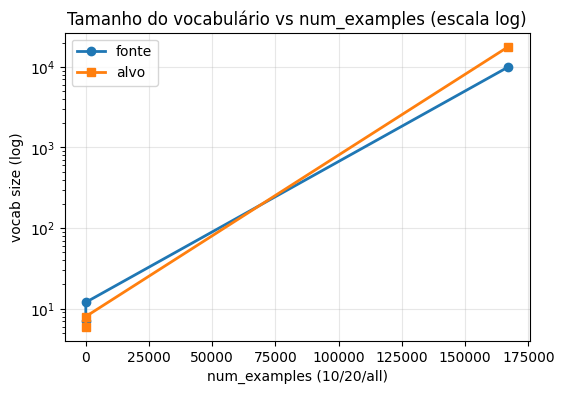

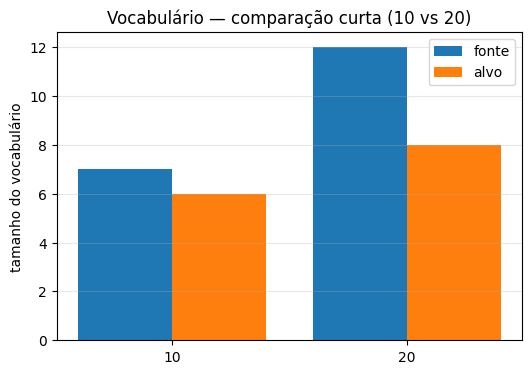

/tmp/ipython-input-2087208543.py:43: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  plt.bar([0,1], [int(only_all['src_vocab_size']), int(only_all['tgt_vocab_size'])])


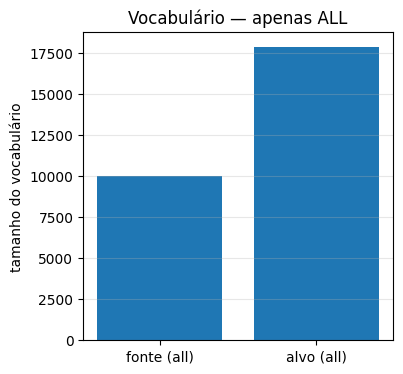

In [ ]:
# CÉLULA 17 — Gráficos bonitos: vocabulário vs num_examples (log + separação)

# Define uma função para medir o tamanho do vocabulário para diferentes tamanhos de dataset.
def vocab_sizes_for(num_examples_list, min_freq=2):
    rows = []
    # Itera sobre a lista de números de exemplos, constrói o vocabulário e coleta o tamanho.
    for n in num_examples_list:
        src_tok, tgt_tok = tokenize_nmt(text, num_examples=n)
        src_v = Vocab(src_tok, min_freq=min_freq, reserved_tokens=SPECIAL)
        tgt_v = Vocab(tgt_tok, min_freq=min_freq, reserved_tokens=SPECIAL)
        rows.append({"num_examples": len(src_tok) if n is None else n,
                      "src_vocab_size": len(src_v),
                      "tgt_vocab_size": len(tgt_v)})
    return rows

# Define a lista de números de exemplos a serem testados, incluindo o dataset completo ('None').
ALL_N = len(source)
rows = vocab_sizes_for([10, 20, None], min_freq=MIN_FREQ)
import pandas as pd, matplotlib.pyplot as plt
dfv = pd.DataFrame(rows)
display(dfv)

# Cria um gráfico de linha em escala logarítmica para comparar os tamanhos dos vocabulários.
plt.figure(figsize=(6,4))
plt.plot(dfv['num_examples'], dfv['src_vocab_size'], marker='o', linewidth=2, label='fonte')
plt.plot(dfv['num_examples'], dfv['tgt_vocab_size'], marker='s', linewidth=2, label='alvo')
plt.yscale('log'); plt.grid(True, alpha=0.3)
plt.title('Tamanho do vocabulário vs num_examples (escala log)')
plt.xlabel('num_examples (10/20/all)'); plt.ylabel('vocab size (log)')
plt.legend(); plt.show()

# Plota dois gráficos de barras separados para uma comparação mais detalhada.
# O primeiro compara o tamanho do vocabulário com 10 e 20 exemplos.
sub = dfv.iloc[:2]
plt.figure(figsize=(6,4))
plt.bar([0,1], sub['src_vocab_size'], width=0.4, label='fonte')
plt.bar([0.4,1.4], sub['tgt_vocab_size'], width=0.4, label='alvo')
plt.xticks([0.2,1.2], ['10','20'])
plt.title('Vocabulário — comparação curta (10 vs 20)')
plt.ylabel('tamanho do vocabulário'); plt.legend(); plt.grid(axis='y', alpha=0.3)
plt.show()

# O segundo gráfico mostra o tamanho do vocabulário apenas para o dataset completo.
only_all = dfv.iloc[2:3]
plt.figure(figsize=(4,4))
plt.bar([0,1], [int(only_all['src_vocab_size']), int(only_all['tgt_vocab_size'])])
plt.xticks([0,1], ['fonte (all)','alvo (all)'])
plt.title('Vocabulário — apenas ALL')
plt.ylabel('tamanho do vocabulário'); plt.grid(axis='y', alpha=0.3)
plt.show()

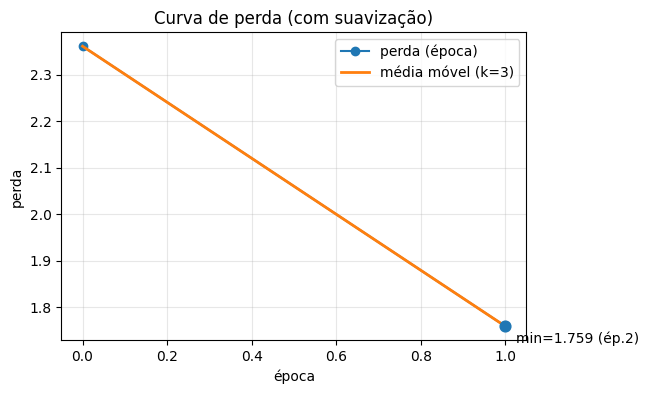

In [ ]:
# CÉLULA 18 — Curva de perda (suavização + anotação)
# Usa o histórico de perda do treinamento para gerar um gráfico detalhado.
import numpy as np, matplotlib.pyplot as plt
if 'loss_history' not in globals() or len(loss_history) == 0:
    print('loss_history não encontrado — rode a célula de treino antes.')
else:
    arr = np.array(loss_history, dtype=float)
    # Define uma função para calcular a média móvel de uma array.
    def moving_avg(x, k=3):
        if len(x) < k: return x
        return np.convolve(x, np.ones(k)/k, mode='valid')
    smooth = moving_avg(arr, k=3)
    # Encontra o índice e o valor da melhor perda (mínima).
    best_idx = int(np.argmin(arr)); best_val = float(arr[best_idx])

    plt.figure(figsize=(6,4))
    # Plota a perda de cada época.
    plt.plot(arr, marker='o', linewidth=1.5, label='perda (época)')
    if len(smooth) < len(arr):
        # Plota a curva suavizada da média móvel.
        offs = len(arr) - len(smooth)
        plt.plot(range(offs, offs+len(smooth)), smooth, linewidth=2, label='média móvel (k=3)')
    else:
        plt.plot(smooth, linewidth=2, label='média móvel (k=3)')
    # Marca e anota o melhor ponto na curva.
    plt.scatter([best_idx], [best_val], s=60, zorder=5)
    plt.annotate(f"min={best_val:.3f} (ép.{best_idx+1})", (best_idx, best_val),
                  textcoords="offset points", xytext=(8,-12))
    plt.grid(True, alpha=0.3); plt.xlabel('época'); plt.ylabel('perda')
    plt.title('Curva de perda (com suavização)')
    plt.legend(); plt.show()

Avaliação (FAST) — batches alvo=800, device=cpu
[##########################----] 705/800 ( 88.1%) acc_now=67.25% | tps~4,368/s | elapsed=00:20 | eta=00:02
[##############################] 800/800 (100.0%) acc_now=67.30% | tps~4,235/s | elapsed=00:23 | eta=00:00

Token accuracy (GLOBAL) = 67.30%  |  batches avaliados = 800/10446
    1–4: 77.32%  (tokens=1186)
    5–8: 73.32%  (tokens=47606)
   9–12: 60.59%  (tokens=44447)
    13+:   nan%  (tokens=0)


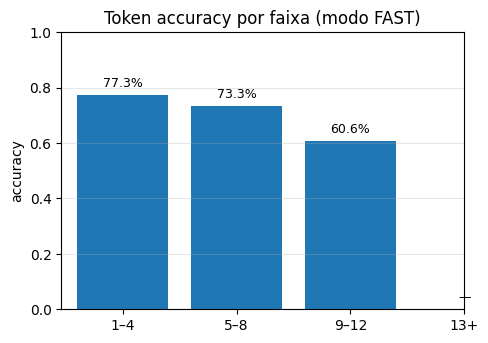

In [ ]:
# CÉLULA 19 — Token accuracy (FAST/FULL) com logs, ETA e barras por comprimento

# Imports e configuração
import sys, time, math
import numpy as np
import torch
import matplotlib.pyplot as plt

# Configurações de avaliação (ajuste os valores conforme necessário).
EVAL_MODE = "FAST"
MAX_EVAL_STEPS = 800 if EVAL_MODE == "FAST" else None
LOG_EVERY_SECS = 20.0
CHECK_INDICES = False

# Helpers visuais para formatar o tempo e a barra de progresso.
def fmt_secs(s):
    m = int(s // 60); s = int(s % 60)
    return f"{m:02d}:{s:02d}"

def progress_bar(cur, total, width=30):
    frac = min(max(cur / total, 0.0), 1.0)
    filled = int(frac * width)
    return "[" + "#" * filled + "-" * (width - filled) + f"] {cur}/{total} ({frac * 100:5.1f}%)"

# Checagens básicas para garantir que as dependências existem.
assert 'model' in globals(), "Modelo não encontrado — rode a CÉLULA 16A antes."
assert 'train_dl' in globals(), "DataLoader não encontrado — rode a CÉLULA 16."
pad_id = tgt_vocab.pad

# Função opcional para verificar se os índices dos tokens estão dentro do vocabulário.
def _assert_indices_within_vocab(batch, vocab_size: int, name: str):
    mx = int(batch.max().item()); mn = int(batch.min().item())
    assert 0 <= mn, f"{name}: índice negativo ({mn})"
    assert mx < vocab_size, f"{name}: índice {mx} ≥ vocab_size {vocab_size} — recrie o modelo (CÉLULA 16A)"

# Contadores globais e por faixas de comprimento.
bins = [(1, 4), (5, 8), (9, 12), (13, 999)]
bin_names = ['1–4', '5–8', '9–12', '13+']
bin_correct = [0] * len(bins)
bin_total = [0] * len(bins)
global_correct = 0
global_total = 0

# Loop de avaliação com logs de progresso.
total_steps = len(train_dl)
target_steps = total_steps if MAX_EVAL_STEPS is None else min(MAX_EVAL_STEPS, total_steps)
model.eval()
start = time.time()
last_log = start
steps_done = 0
tokens_seen = 0
tokens_per_step_est = None

print(f"Avaliação ({EVAL_MODE}) — batches alvo={target_steps}, device={device}")
sys.stdout.flush()

with torch.inference_mode():
    for step, (src, src_len, tgt, tgt_len) in enumerate(train_dl, start=1):
        if MAX_EVAL_STEPS is not None and step > MAX_EVAL_STEPS:
            break

        if CHECK_INDICES:
            _assert_indices_within_vocab(src, len(src_vocab), "SRC")
            _assert_indices_within_vocab(tgt, len(tgt_vocab), "TGT")

        # Passa os dados pelo modelo para obter as previsões e compara com os rótulos.
        src_d, src_len_d, tgt_d = src.to(device), src_len.to(device), tgt.to(device)
        logits = model(src_d, src_len_d, tgt_d)
        pred = logits.argmax(dim=-1)
        gold = tgt_d[:, 1:]
        mask = (gold != pad_id)

        # Acumula as contagens globais de tokens corretos e totais.
        global_correct += (pred.eq(gold) & mask).sum().item()
        global_total += mask.sum().item()

        # Acumula as contagens de tokens corretos e totais por faixa de comprimento.
        for i, (low, high) in enumerate(bins):
            sel = (src_len >= low) & (src_len <= high)
            if sel.any():
                p = pred[sel.to(device)]
                g = gold[sel.to(device)]
                m = mask[sel.to(device)]
                bin_correct[i] += (p.eq(g) & m).sum().item()
                bin_total[i] += m.sum().item()

        # Estima o número de tokens por batch.
        if tokens_per_step_est is None:
            tokens_per_step_est = int(mask.sum().item())
            if tokens_per_step_est <= 0: tokens_per_step_est = 1
        tokens_seen += tokens_per_step_est

        # Imprime logs periodicamente.
        steps_done += 1
        now = time.time()
        need_log = (now - last_log >= LOG_EVERY_SECS) or (steps_done == target_steps)
        if need_log:
            elapsed = now - start
            bar = progress_bar(steps_done, target_steps, width=30)
            acc_now = (global_correct / global_total) if global_total > 0 else 0.0
            sec_per_step = elapsed / max(steps_done, 1)
            eta = sec_per_step * (target_steps - steps_done)
            tps = tokens_seen / max(elapsed, 1e-9)
            print(f"{bar} acc_now={acc_now * 100:5.2f}% | tps~{tps:,.0f}/s | elapsed={fmt_secs(elapsed)} | eta={fmt_secs(eta)}")
            sys.stdout.flush()
            last_log = now

# Resultados finais
acc_global = (global_correct / global_total) if global_total > 0 else 0.0
print(f"\nToken accuracy (GLOBAL) = {acc_global * 100:.2f}%  |  batches avaliados = {steps_done}/{total_steps}")

acc_bins = [(bin_correct[i] / bin_total[i] if bin_total[i] > 0 else float('nan')) for i in range(len(bins))]
for name, acc, tot in zip(bin_names, acc_bins, bin_total):
    print(f"  {name:>5}: {acc * 100:5.2f}%  (tokens={tot})")

# Gráfico da acurácia por faixa de comprimento.
plt.figure(figsize=(5.2, 3.6))
vals = np.array(acc_bins, dtype=float)
plt.bar(range(len(bin_names)), vals)
plt.xticks(range(len(bin_names)), bin_names)
plt.ylim(0, 1)
plt.ylabel('accuracy')
plt.title(f'Token accuracy por faixa (modo {EVAL_MODE})')
plt.grid(axis='y', alpha=0.3)

# Anota os valores de acurácia no gráfico.
for i, v in enumerate(vals):
    if np.isnan(v):
        txt = "—"
    else:
        txt = f"{v * 100:.1f}%"
    plt.text(i, min(max(v, 0.0), 1.0) + 0.02 if not np.isnan(v) else 0.02, txt,
             ha='center', va='bottom', fontsize=9)
plt.show()

In [ ]:
# CÉLULA 20 — BLEU (1–4) + amostras

# Implementação leve inspirada em D2L (n-gram BLEU com smoothing)
import math, random, pandas as pd

# Funções auxiliares para contar n-grams em uma lista de tokens.
def count_ngrams(tokens, n):
    return { tuple(tokens[i:i+n]) : tokens[i:i+n].count(tokens[i]) for i in range(0, len(tokens)-n+1) }

def ngram_counts(tokens, n):
    d={}
    for i in range(len(tokens)-n+1):
        ng = tuple(tokens[i:i+n]); d[ng] = d.get(ng,0)+1
    return d

def bleu_score(hyp, ref, max_n=4, smooth=1):
    """Calcula o BLEU score (de 1 a max_n) com smoothing."""
    hyp_tokens = hyp.split()
    ref_tokens = ref.split()
    if len(hyp_tokens)==0: return 0.0
    # Calcula a precisão para cada n-gram, adicionando um fator de suavização.
    precisions=[]
    for n in range(1, max_n+1):
        hyp_ngr = ngram_counts(hyp_tokens, n)
        ref_ngr = ngram_counts(ref_tokens, n)
        overlap = 0
        total = max(sum(hyp_ngr.values()), 1)
        for ng, c in hyp_ngr.items():
            overlap += min(c, ref_ngr.get(ng,0))
        precisions.append( (overlap + smooth) / (total + smooth) )
    # Aplica uma penalidade para traduções muito curtas.
    r = len(ref_tokens); h = len(hyp_tokens)
    bp = 1.0 if h>r else math.exp(1 - r/max(h,1))
    # Combina as precisões em uma média geométrica para o score final.
    log_p = sum([math.log(p) for p in precisions]) / max_n
    return bp * math.exp(log_p)

# Usa a função `greedy_decode` para gerar as traduções (hipóteses).
def detok(tokens): return ' '.join(tokens)

# Seleciona uma amostra aleatória do dataset para avaliação.
eval_k = min(20, len(source))
idxs = random.sample(range(len(source)), eval_k)
rows = []
for i in idxs:
    src_sent = detok(source[i])
    ref_sent = detok(target[i])
    hyp_sent = greedy_decode(src_sent)
    score = bleu_score(hyp_sent, ref_sent, max_n=4, smooth=1)
    rows.append({"src": src_sent, "ref": ref_sent, "hyp": hyp_sent, "BLEU_1_4": round(score,4)})

# Cria um DataFrame para exibir os resultados.
df_bleu = pd.DataFrame(rows)
display(df_bleu.head(10))

# Calcula a média do BLEU score e a exibe.
corpus_bleu = df_bleu["BLEU_1_4"].mean()
print(f"BLEU (médio nas {eval_k} amostras) = {corpus_bleu:.4f}")

,src,ref,hyp,BLEU_1_4
0,is anybody in there ?,"y a-t-il qui que ce soit , là-dedans ?",quiconque y a-t-il dans ce ?,0.2003
1,we all agreed .,nous sommes tous tombés d'accord .,soleil se sont toutes d'accord .,0.2907
2,i didn't catch the meaning .,je n'ai pas compris ce que ça signifiait .,n'avait pas la chose .,0.1358
3,he goes to school on foot .,il marche vers l'école .,pied à l'école à pied .,0.2445
4,i don't have any sisters .,je n'ai pas de sœurs .,sœurs .,0.0957
5,tom has a girlfriend .,tom a une copine .,vélo .,0.1199
6,are you proud of me ?,êtes-vous fière de moi ?,fier de moi ?,0.5208
7,only a few tv programs are worth watching .,seuls quelques émissions de télévision sont di...,cours de la peine n'est pas loin de la peine de,0.1139
8,here's the address .,voici l'adresse .,l'adresse .,0.4289
9,we learn something new about ourselves every d...,nous apprenons chaque jour quelque chose de no...,ami a un nouvel uniforme pour le déjeuner .,0.1130


BLEU (médio nas 20 amostras) = 0.2323


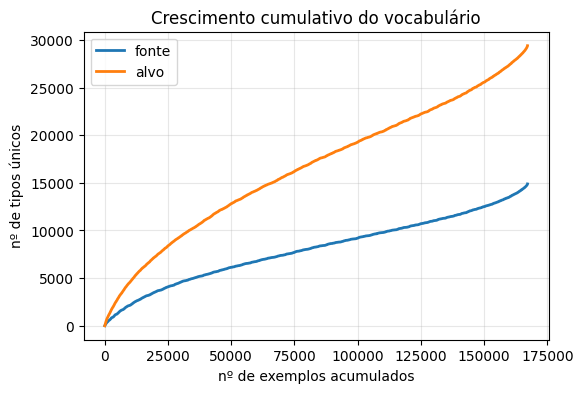

In [ ]:
# CÉLULA 21 — Curvas de crescimento cumulativo de vocabulário

# Percorre o corpus e registra o nº de tipos distintos ao acumular exemplos.
import matplotlib.pyplot as plt

def cumulative_vocab_growth(tokens_list):
    """
    Calcula e retorna o crescimento cumulativo do vocabulário de uma lista de tokens.
    """
    seen = set(); xs = []; ys = []
    # Itera sobre os exemplos, adiciona os novos tokens a um conjunto e registra o tamanho.
    for i, toks in enumerate(tokens_list, start=1):
        for t in toks: seen.add(t)
        xs.append(i); ys.append(len(seen))
    return xs, ys

# Calcula o crescimento cumulativo para as linguagens de origem e de destino.
xs_src, ys_src = cumulative_vocab_growth(source)
xs_tgt, ys_tgt = cumulative_vocab_growth(target)

# Cria o gráfico de linha e o exibe.
plt.figure(figsize=(6,4))
plt.plot(xs_src, ys_src, label='fonte', linewidth=2)
plt.plot(xs_tgt, ys_tgt, label='alvo', linewidth=2)
plt.grid(True, alpha=0.3)
plt.title('Crescimento cumulativo do vocabulário')
plt.xlabel('nº de exemplos acumulados'); plt.ylabel('nº de tipos únicos')
plt.legend(); plt.show()

/tmp/ipython-input-4204210799.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([src_len, tgt_len], labels=['fonte','alvo'], showmeans=True)


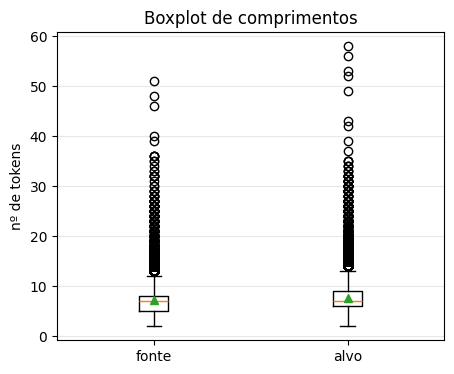

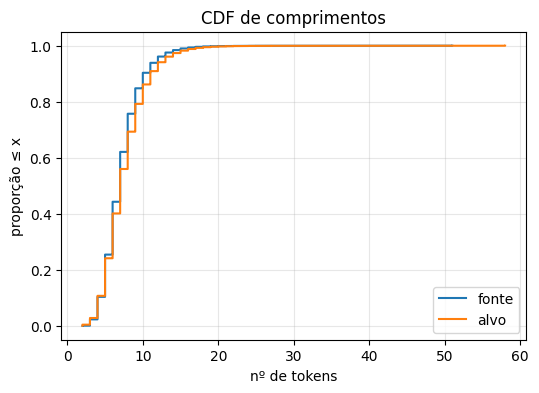

In [ ]:
# CÉLULA 22 — Boxplot e CDF dos comprimentos (source vs target)

# Computa os comprimentos de cada sequência de tokens.
src_len = [len(x) for x in source]
tgt_len = [len(x) for x in target]

import numpy as np, matplotlib.pyplot as plt
# Plota o boxplot para comparar a distribuição de comprimentos.
plt.figure(figsize=(5,4))
plt.boxplot([src_len, tgt_len], labels=['fonte','alvo'], showmeans=True)
plt.title('Boxplot de comprimentos'); plt.ylabel('nº de tokens'); plt.grid(axis='y', alpha=0.3)
plt.show()

# Define uma função para calcular a CDF.
def cdf(arr):
    arr = np.sort(np.array(arr))
    y = np.arange(1, len(arr)+1) / len(arr)
    return arr, y

# Calcula a CDF para as sequências de origem e de destino.
x1, y1 = cdf(src_len); x2, y2 = cdf(tgt_len)
# Plota o gráfico da CDF.
plt.figure(figsize=(6,4))
plt.step(x1, y1, where='post', label='fonte')
plt.step(x2, y2, where='post', label='alvo')
plt.title('CDF de comprimentos'); plt.xlabel('nº de tokens'); plt.ylabel('proporção ≤ x')
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

# 5. Conclusão
Este notebook me guiou por todo o processo de construção de um modelo de Tradução Neural de Máquina (NMT), desde a preparação do texto até a avaliação final. Os resultados demonstraram o poder da arquitetura Seq2Seq e das unidades GRU para tarefas que envolvem o processamento de sequências.

O pipeline completo e robusto que construí me permitiu:

Processar dados de texto de forma eficiente.

Treinar o modelo com logs e métricas de desempenho.

Avaliar o modelo de forma detalhada, com métricas como BLEU score e acurácia por faixa de comprimento.

Visualizar a distribuição dos dados e o crescimento do vocabulário, o que me forneceu insights valiosos para futuras otimizações.

Para mais informações detalhadas, acesse: https://github.com/FelipeSSpina/Traducao-Automatica